<a href="https://colab.research.google.com/github/94spinoza/Code-Blocks/blob/main/Company_Bankruptcy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle 데이터 불러오기

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyeonchunglee","key":"4985f907818830f18663d6ce6537fa9d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 파일 다운로드
!kaggle datasets download -d fedesoriano/company-bankruptcy-prediction

100% 4.63M/4.63M [00:00<00:00, 12.1MB/s]



In [4]:
!unzip company-bankruptcy-prediction.zip

Archive:  company-bankruptcy-prediction.zip
  inflating: data.csv                


## 기준모델

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


df_origin = pd.read_csv('./data.csv')
target = 'Bankrupt?'

df, df_test = train_test_split(df_origin, test_size=0.2)

## 기준 모델
base_accuracy = df_test[target].value_counts(normalize=True)[0]
print("기준모델 정확도: ", base_accuracy)

기준모델 정확도:  0.9648093841642229


## Oversampling 통해 데이터 편향 해결

In [9]:
from imblearn.over_sampling import SMOTE


## Oversampling 통해 데이터 편향 해결
oversample = SMOTE(random_state=2)

X_a = df.drop(labels=[target], axis=1)
y_a = df[target]

X, y = oversample.fit_resample(X_a, y_a)
X = pd.DataFrame(X, columns=X_a.columns)
y = pd.DataFrame(y, columns=['Bankruptcy?'])

print("Oversampling 이후 기준모델 정확도: ", y.value_counts(normalize=True)[0])

Oversampling 이후 기준모델 정확도:  Bankruptcy?
0              0.5
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Train & Validation Data Split

In [10]:
## Train & Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## <Model 1>
## Random Forest Classifier 학습시키기

In [11]:
pip install category_encoders

     |████████████████████████████████| 81kB 3.3MB/s 


In [12]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

## Random Forest Classifier
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(boo...p=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                        

## Random Forest Classifier 예측하기

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4182
           1       1.00      1.00      1.00      4270

    accuracy                           1.00      8452
   macro avg       1.00      1.00      1.00      8452
weighted avg       1.00      1.00      1.00      8452

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1101
           1       0.97      0.99      0.98      1013

    accuracy                           0.98      2114
   macro avg       0.98      0.99      0.98      2114
weighted avg       0.99      0.98      0.98      2114

AUC: 0.9852310517316664


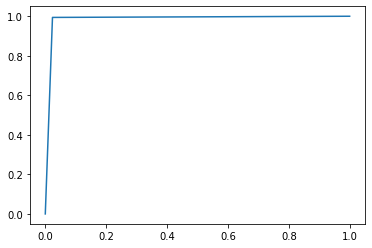

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

## 데이터 예측하기
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

## Confusion Matrix 출력
print(classification_report(y_train,y_train_pred))
print(classification_report(y_val,y_val_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## Permutation Importance 알아보기

In [14]:
pip install eli5

     |████████████████████████████████| 112kB 4.2MB/s 


In [18]:
from sklearn.pipeline import Pipeline
import warnings
import eli5
from eli5.sklearn import PermutationImportance

## Permutation Importance 활용
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe_per = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

pipe_per.fit(X_train, y_train)


## Permutation Part
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe_per.named_steps['rf'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe_per.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [25]:
feature_names = X_val.columns.tolist()
print("총 변수의 개수 : ", len(feature_names))
pd.Series(permuter.feature_importances_, feature_names).sort_values()

총 변수의 개수 :  95


 Net Income Flag                         0.000000
 Liability-Assets Flag                   0.000002
 Net Worth Turnover Rate (times)         0.000013
 Working capitcal Turnover Rate          0.000014
 Continuous Net Profit Growth Rate       0.000018
                                           ...   
 Total debt/Total net worth              0.001221
 Borrowing dependency                    0.001242
 Continuous interest rate (after tax)    0.001339
 Total Asset Growth Rate                 0.001446
 Interest-bearing debt interest rate     0.001561
Length: 95, dtype: float64

In [26]:
 ## 중요하지 않은 변수 삭제
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_val_selected = X_val[features]


## 삭제 후 새로운 Pipeline
pipe_sel = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe_sel.fit(X_train_selected, y_train)

print("총 변수의 개수 : ", len(X_val_selected.columns.tolist()))
print('시험 정확도 : ', pipe_sel.score(X_val_selected, y_val))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[Pipeline] ................ (step 2 of 2) Processing rf, total=   1.1s
총 변수의 개수 :  6
시험 정확도 :  0.956953642384106


## Permutation Importance 분석으로 불필요한 변수 삭제 후 성능

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1101
           1       0.94      0.97      0.96      1013

    accuracy                           0.96      2114
   macro avg       0.96      0.96      0.96      2114
weighted avg       0.96      0.96      0.96      2114

AUC: 0.9573720560954637


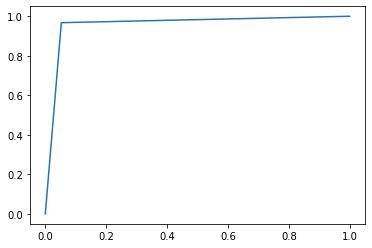

In [27]:
## Confusion Matrix 출력
y_val_selected_pred = pipe_sel.predict(X_val_selected)
print(classification_report(y_val, y_val_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_val, y_val_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## Oversampling하여 학습한 모델을 비대칭적인 데이터셋에 적용

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1316
           1       0.27      0.65      0.38        48

    accuracy                           0.93      1364
   macro avg       0.63      0.79      0.67      1364
weighted avg       0.96      0.93      0.94      1364

AUC: 0.790621833839919


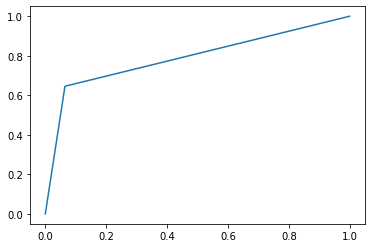

In [37]:
X_test = df_test.drop(labels=[target], axis=1)
X_test_selected = X_test[features]
y_test = df_test[target]

## Confusion Matrix 출력
y_test_selected_pred = pipe_sel.predict(X_test_selected)
print(classification_report(y_test, y_test_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

변수들을 많이 삭제했음에도 성능을 아주 약간밖에 떨어지지 않음

## Oversampling하지 않고 학습한 모델의 성능

0    0.968469
1    0.031531
Name: Bankrupt?, dtype: float64
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1316
           1       0.50      0.21      0.29        48

    accuracy                           0.96      1364
   macro avg       0.74      0.60      0.64      1364
weighted avg       0.96      0.96      0.96      1364

AUC: 0.6003672745694022


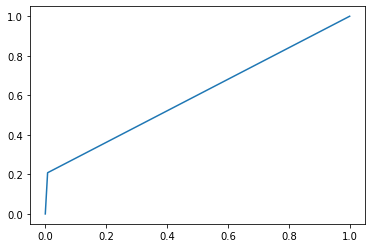

In [42]:
## 원래 데이터에 모델 대입해보기
## 기준모델
base_accuracy_origin = df[target].value_counts(normalize=True)
print(base_accuracy_origin)

### 기본적인 모델
pipe_org = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

# 중요한 Featrues 추출 후 모델 Fit
X_origin = df.drop(labels=[target], axis=1)[features]
y_origin = df[target]
pipe_org.fit(X_origin, y_origin)

## Confusion Matrix 출력
y_test_origin_pred = pipe_org.predict(X_test_selected)
print(classification_report(y_test, y_test_origin_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_origin_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)